In [ ]:
import scipy.io
import numpy as np
%matplotlib inline

In [ ]:
data = scipy.io.loadmat("SignalTag.mat")
data_arr = np.genfromtxt('myfile.csv', delimiter=',')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from scipy import signal

t_data = np.reshape(data_arr[0], [100, 15000])
sos = signal.butter(100 , [1000, 8000] , 'bp', output='sos', fs = 20000)
filtered = signal.sosfilt(sos, t_data)

In [ ]:
def spike_detect(ds, thresh):
    n = len(ds)
    # 2*spike_array
    bi2 = np.zeros(n+1)
    # -1*spike_array
    bi_1 = np.zeros(n+1)

    # keeping values below threshold
    for i in range(n):
        if ds[i]<=thresh:
            bi2[i] = 2
            bi_1[i+1] = -1
    # an array including 0, 1, 2, and -1 values which indicates accurance of spikes
    a = bi2 + bi_1

    # index of arrays that are equal to 2
    y = np.where(a==2)

    '''
    this function returns a 0,1 list for spike accurance
    '''
    return y[0]

# function that returns a list that contains y points of each spike
def spike_graph(data, spike):
    g = np.array([])
    for i, s in enumerate(spike):
        lower_lim = s - 7
        upper_lim = s + 10
        g = np.append(g, data[lower_lim:upper_lim])
    return g


def spike_graph_mod(data, spike):
    g = np.array([])
    for i, s in enumerate(spike):
        lower_lim = s - 2
        upper_lim = s + 3
        g = np.append(g, data[lower_lim:upper_lim])
    return g

# function that returns amplitude of each spike
def amplitude(data, spike):
    amplitude = []
    spike_form = spike_graph_mod(data, spike)
    for i in range(len(spike)):
        amplitude.append(np.min(spike_form[i]))

    return amplitude

# function that returs duration of each spike
# Spike duration is measured from the peak of the spike to when membrane potential declines to 33% of peak amplitude.

def duration(data, spike):
    n = len(spike)
    dur = []
    s_g = spike_graph_mod(data, spike)
    amp = amplitude(data, spike)

    for i in range(n):
        y_spike = s_g[i]
        y_33 = [0.33*amp[i]]*len(y_spike)
        xs= np.arange(0,len(y_spike))/30
        idx= np.argwhere(np.diff(np.sign(y_spike - y_33 )) != 0).reshape(-1) + 0
        if len(idx)>1:
            slop = (y_spike[idx[1]+1]-y_spike[idx[1]])/(xs[idx[1]+1] - xs[idx[1]])
            x_inter = (y_33[0] - y_spike[idx[1]])/slop + xs[idx[1]]
            dur.append((x_inter -xs[2]))
        else:
            dur.append(np.nan)

    return dur

# function that returns energy of each spike
def energy(data, spike):
    s = spike_graph_mod(data, spike)
    energy = []
    n = len(s)
    for i in range(n):
        e = 0
        for j in range(len(s[i])):
            e += s[i][j]**2
        energy.append(e)
    return energy

In [ ]:
# All the data from channel one
channel1_f = np.array([])
for i in range(100):
    channel1_f = np.append(channel1_f, filtered[i])
# All the spikes from channel one
spike_c1 = spike_detect(channel1_f, -100)# All the data from channel one

In [ ]:
import pandas as pd


amp = np.array(amplitude(channel1_f, spike_c1))
dur = np.array(duration(channel1_f, spike_c1))
eng = np.array(energy(channel1_f, spike_c1))
index = np.arange(5093)

features = np.concatenate(([amp], [dur], [eng], [index]))
features = np.transpose(features)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
#now we try dropping null values
df2 = pd.DataFrame(features, columns = ['Amplitude', 'Duration', 'Energy', 'index'])
df2

,Amplitude,Duration,Energy,index
0,-105.638958,0.047181,23271.947809,0.0
1,-104.750843,0.063071,21603.375963,1.0
2,-140.418325,0.026807,35291.833425,2.0
3,-116.380501,0.026672,20772.169046,3.0
4,-102.044617,0.046732,19619.997980,4.0
...,...,...,...,...
5088,-107.963526,0.039500,21269.662458,5088.0
5089,-125.255042,0.065412,33586.014340,5089.0
5090,-108.201828,0.043919,22072.521699,5090.0
5091,-114.636898,0.043366,21643.087693,5091.0


In [ ]:
df2.isnull().sum()

Amplitude      0
Duration     892
Energy         0
index          0
dtype: int64

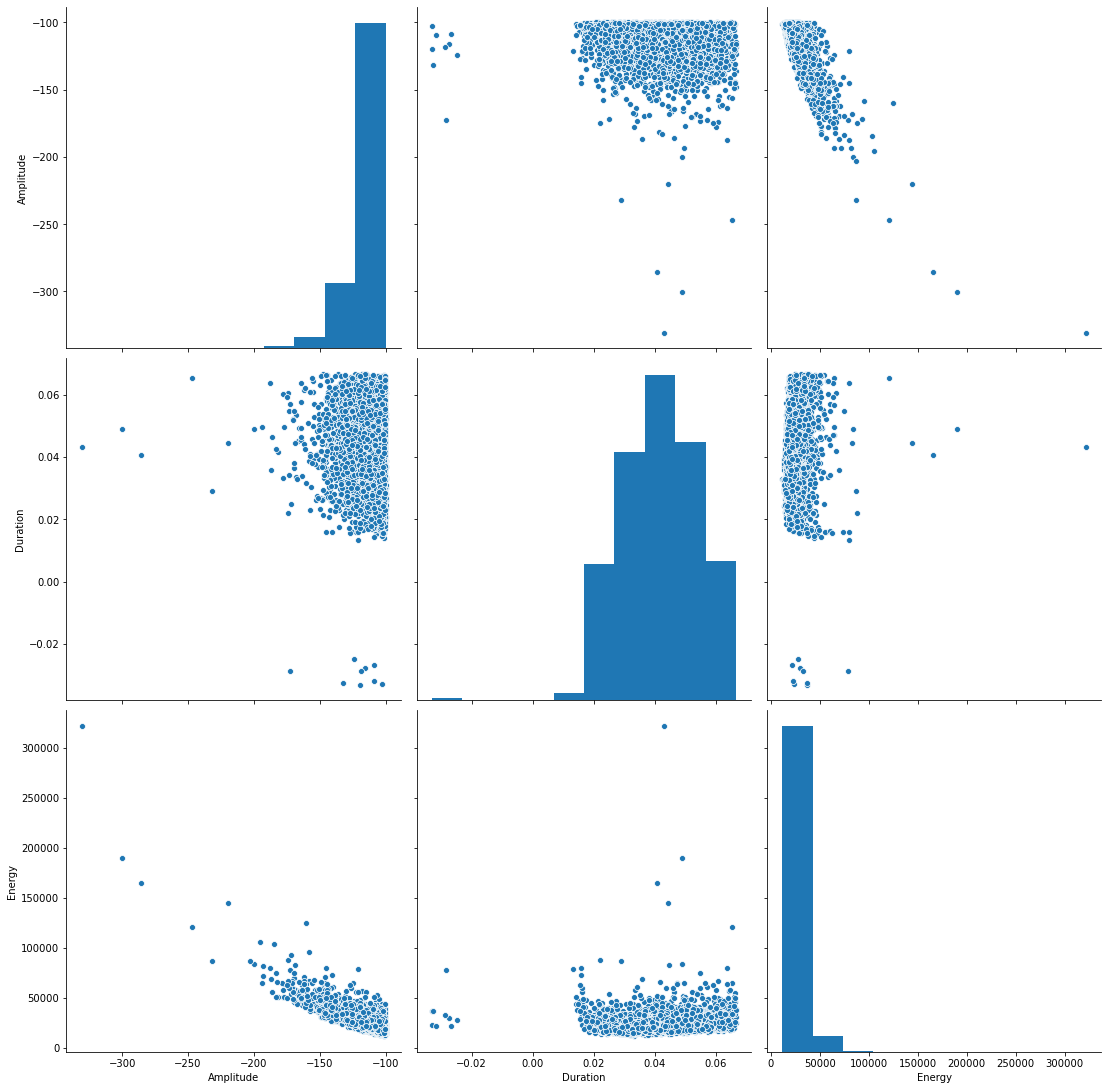

In [ ]:
import seaborn as sns

sns.pairplot(df2.drop('index', axis='columns') , height = 5)

In [ ]:
df2 = df2.dropna()
df2.isnull().sum()

Amplitude    0
Duration     0
Energy       0
index        0
dtype: int64

In [ ]:
final_features2 = df2.drop('index', axis = 'columns').values
model2 = KMeans(n_clusters = 2)
model2.fit(final_features2)
KMeans(algorithm = 'auto')
labels2 = model2.predict(final_features2)

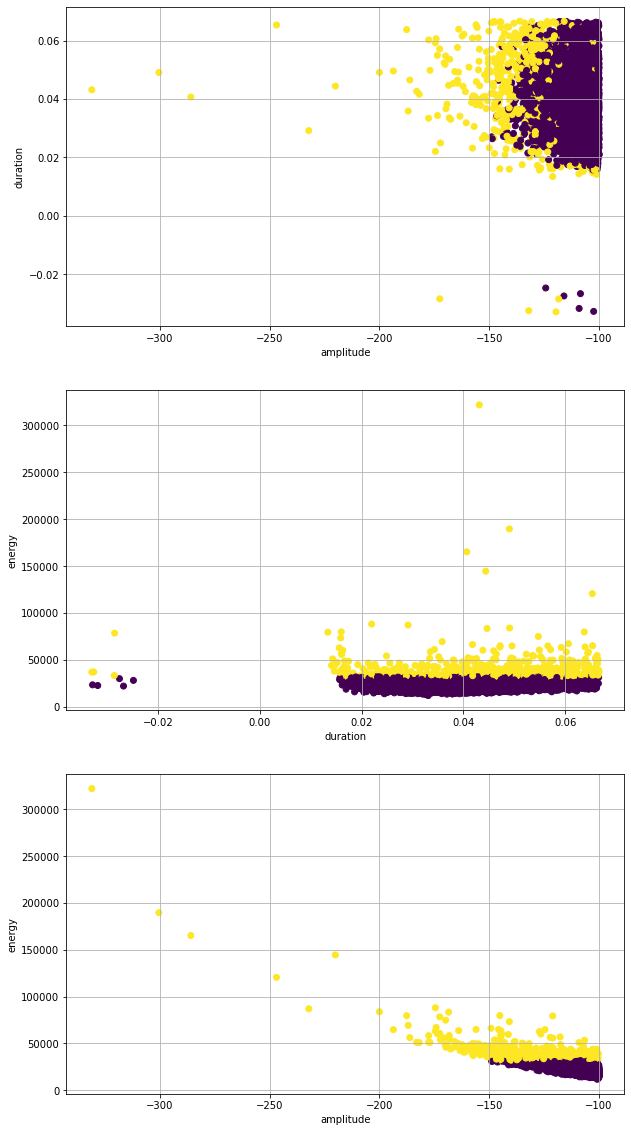

In [ ]:
fig2, ax2 = plt.subplots(3)
fig2.set_figwidth(10)
fig2.set_figheight(20)
ax2[0].set(xlabel='amplitude', ylabel='duration')
ax2[0].scatter(final_features2[:,0], final_features2[:,1], c = labels2)
ax2[0].grid()

ax2[1].set(xlabel='duration', ylabel='energy')
ax2[1].scatter(final_features2[:,1], final_features2[:,2], c = labels2)
ax2[1].grid()

ax2[2].set(xlabel='amplitude', ylabel='energy')
ax2[2].scatter(final_features2[:,0], final_features2[:,2], c = labels2)
ax2[2].grid()

In [ ]:
first_wave_form = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
second_wave_form = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

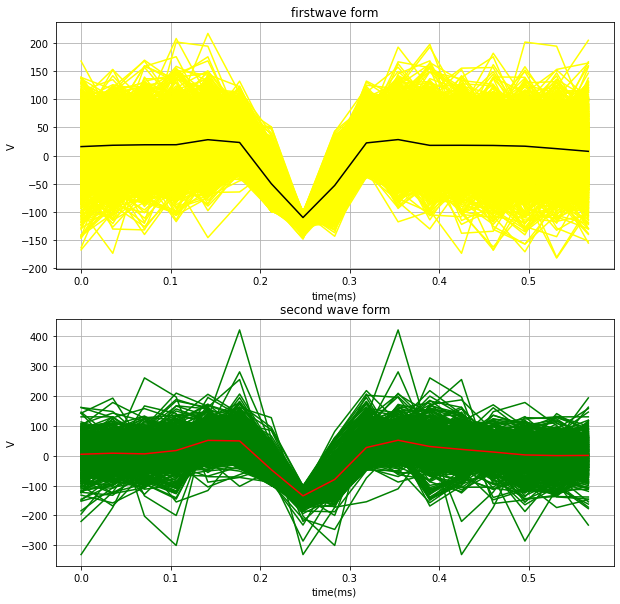

In [ ]:
fig, ax = plt.subplots(2)
fig.set_figwidth(10)
fig.set_figheight(10)
ax[0].set(xlabel = 'time(ms)', ylabel = 'V', title = 'firstwave form')
ax[1].set(xlabel = 'time(ms)', ylabel = 'V', title = 'second wave form')
ax[0].grid()
ax[1].grid()

indices = df2['index'].values
len_in = len(indices)
n1, n2 = 0, 0
for i in range(len(labels2)):
    index = int(indices[i])
    if labels2[i]==0:
        n1+=1
        s1 = spike_graph(channel1_f, spike_c1[index:index+1])
        ax[0].plot(np.linspace(0,17/30, len(s1)), s1, color = 'yellow')
        first_wave_form += s1
    if labels2[i]==1:
        n2+=1
        s2 =  spike_graph(channel1_f, spike_c1[index:index+1])
        ax[1].plot(np.linspace(0,17/30, len(s2)), s2, color = 'green')
        second_wave_form += s2
first_wave_form = first_wave_form/n1
second_wave_form = second_wave_form/n2

ax[0].plot(np.linspace(0,17/30, len(first_wave_form)), first_wave_form, color = 'black')
ax[1].plot(np.linspace(0,17/30, len(second_wave_form)), second_wave_form, color = 'red')
